**Bibliotecas:** <br>
**torch**: Biblioteca principal para aprendizado de máquina e deep learning em PyTorch.<br>
**torchvision.transforms**: Fornece transformações para pré-processamento de imagens.<br>
**facenet_pytorch**: Contém o modelo InceptionResnetV1 pré-treinado e o detector de faces MTCNN.<br>
**PIL**: Usado para manipulação de imagens.<br>
**numpy**: Biblioteca para operações numéricas.<br>
**matplotlib.pyplot**: Usado para visualização e plotagem de gráficos.<br>
**os**: Biblioteca para manipulação de caminhos e arquivos no sistema operacional.

In [1]:
import torch
import torchvision.transforms as transforms
!pip install facenet_pytorch
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

Aqui, o MTCNN é inicializado para detecção de faces e o InceptionResnetV1 é carregado com pesos pré-treinados no dataset VGGFace2 para extração de características faciais.

In [2]:
mtcnn = MTCNN(image_size=160, margin=0)
model = InceptionResnetV1(pretrained='vggface2').eval()

Esta função carrega uma imagem, detecta e recorta a face usando MTCNN, e depois extrai um vetor de características (embedding) da face usando o modelo InceptionResnetV1.

In [3]:
def extract_features(img_path):
    img = Image.open(img_path)
    img_cropped = mtcnn(img)
    if img_cropped is not None:
        img_embedding = model(img_cropped.unsqueeze(0))
        return img_embedding.detach().numpy()
    else:
        return None

Esta função percorre um diretório de imagens e retorna todos os caminhos de arquivos de imagens válidas. <br>
Aqui, a função get_all_image_paths é usada para obter os caminhos das imagens de celebridades. Em seguida, para cada imagem, as características são extraídas usando extract_features e armazenadas em um dicionário celebrity_embeddings.

In [4]:
def get_all_image_paths(root_dir):
    image_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                image_paths.append(root)
    return image_paths

celebrity_images_path = 'post-processed'
image_paths = get_all_image_paths(celebrity_images_path)

celebrity_embeddings = {}

for img_path_item in image_paths:
    for img_name in os.listdir(img_path_item):
        img_path = os.path.join(celebrity_images_path, img_name)
        embedding = extract_features(img_path)
        if embedding is not None:
            celebrity_embeddings[img_name] = embedding

Aqui, uma nova imagem, vulgo Marcelinho, é processada para extrair características e adicionada ao banco de dados de embeddings.

In [9]:
new_person_image_path = '/content/drive/MyDrive/Teste Daedalus/reconhecimento_facial/marcelinho_no_db.jpg'
new_person_embedding = extract_features(new_person_image_path)
if new_person_embedding is not None:
    celebrity_embeddings['new_person'] = new_person_embedding

As características da imagem sem máscara (original) e com máscara são extraídas.

In [6]:
new_person_image_path = '/content/drive/MyDrive/Teste Daedalus/reconhecimento_facial/marcelinho_no_db.jpg'
masked_image_path = '/content/drive/MyDrive/Teste Daedalus/reconhecimento_facial/marcelinho_na_inferencia.jpg'

new_person_embedding = extract_features(new_person_image_path)
masked_embedding = extract_features(masked_image_path)

Esta função calcula a similaridade cosseno entre dois vetores de características, que é uma métrica comum para comparar embeddings. <br>
Logo depois, a similaridade cosseno é calculada entre o embedding da imagem com máscara e todos os embeddings no banco de dados. O melhor match é armazenado.

In [7]:
def cosine_similarity(embedding1, embedding2):
    # Certificando-se de que a saída seja um escalar
    embedding1 = embedding1.flatten()
    embedding2 = embedding2.flatten()
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

# Comparar e encontrar o melhor match
best_match = None
best_score = -1

for name, embedding in celebrity_embeddings.items():
    score = cosine_similarity(masked_embedding, embedding)
    if score > best_score:
        best_match = name
        best_score = score

As imagens original e com máscara são exibidas lado a lado com as informações de identificação e a pontuação de similaridade.

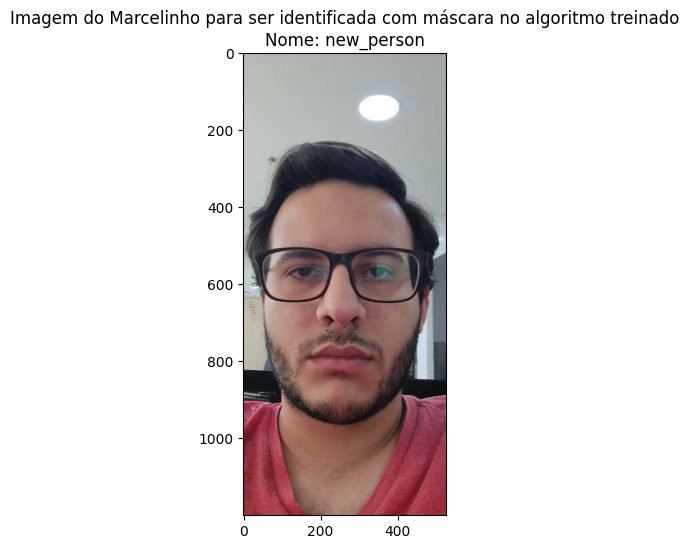

Text(0.5, 1.0, 'Imagem do Marcelinho com máscara identificada com uma precisão razoável pelo algoritmo treinado\nIdentificado como: new_person\nScore: 0.41')

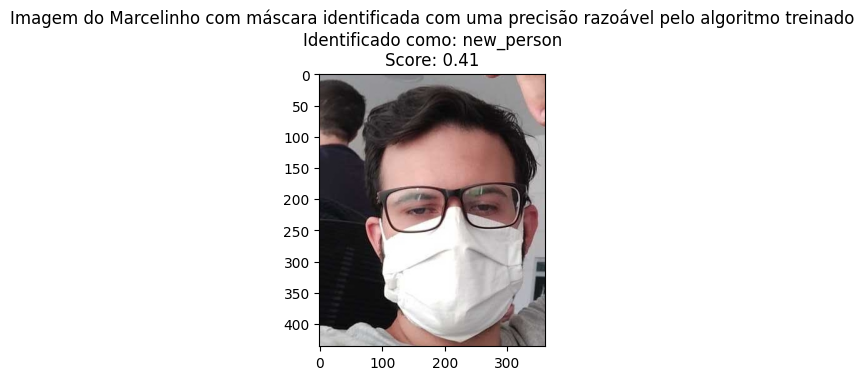

In [8]:
masked_img = Image.open(masked_image_path)
plt.figure(figsize=(12, 6))

if best_match and best_match in celebrity_embeddings:
    new_person_img = Image.open(new_person_image_path)
    plt.subplot(1, 2, 2)
    plt.imshow(new_person_img)
    plt.title(f'Imagem do Marcelinho para ser identificada com máscara no algoritmo treinado\nNome: {best_match}')

plt.show()

plt.subplot(1, 2, 1)
plt.imshow(masked_img)
plt.title(f'Imagem do Marcelinho com máscara identificada com uma precisão razoável pelo algoritmo treinado\nIdentificado como: {best_match}\nScore: {best_score:.2f}')

**Conclusão**: O código implementa um pipeline de reconhecimento facial baseado em aprendizado de métrica, usando embeddings gerados por um modelo pré-treinado (InceptionResnetV1) para comparar faces, mesmo com a presença de máscaras. A visualização final permite verificar a precisão do modelo ao identificar uma pessoa usando máscara, que no nosso caso deu certo, conseguimos identificar o Marcelinho de máscara com um score de similaridade de: 41%